In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import io
from pprint import pprint
from time import time

from google.cloud import vision
from google.cloud.vision import types
import matplotlib.pyplot as plt

from context import backend
from backend.apps.detections import fix_ros_path  # needs to be before cv2 import
import cv2
from backend.apps.detections.gcv_api import VisionClient 
from backend.apps.detections.cv_helpers import image_resize
from backend.apps.detections.gcv_api import bb_norm_to_corner_pixels, objects_dict_coords_to_pic

In [4]:
DIR = '/home/matt/polybox/Fotos'
FILE_NAME = 'lessdark.jpg'
FILE_PATH = os.path.join(DIR, FILE_NAME)

def read_img_bin(path):
    with io.open(path, 'rb') as image_file:
        return image_file.read()
    
def read_img_cv(path):
    return cv2.imread(path)

In [5]:
"""Plotting"""

def show_detections(img_cv, objects):
    font                   = cv2.FONT_HERSHEY_DUPLEX
    fontScale              = 2
    fontColor              = (255, 255, 255)
    lineType               = 2

    for pred in objects:
        bbox_pix = pred['bb_vertices']  
        top_left_x, top_left_y = bbox_pix[0]['x'], bbox_pix[0]['y']
        bottom_right_x, bottom_right_y = bbox_pix[2]['x'], bbox_pix[2]['y']
        img_cv = cv2.rectangle(img_cv, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0,0,255), 2)

        img_cv = cv2.putText(img_cv,f'{pred["obj_name"]}, acc: {round(pred["confidence"], 2)}', 
            (top_left_x, top_left_y-5), 
            font, 
            fontScale,
            fontColor,
            lineType)

    cv2.imshow('img', image_resize(img_cv, height=800))



In [6]:
DIR = '/home/matt/polybox/Fotos/Yb/'
FILES = []

files = FILES if len(FILES) != 0 else os.listdir(DIR)
paths = [os.path.join(DIR, f) for f in files]
paths = []
for path in paths:
    print(path)
    img_cv = read_img_cv(path)
    img_bin = read_img_bin(path)
    vision_client = VisionClient()
    objects = vision_client.localize_objects(img_bin)
    objects_dict_coords_to_pic(objects, img_cv.shape)
    show_detections(img_cv, objects)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
import torchvision
from PIL import Image
import PIL

mobilenet = torchvision.models.mobilenet_v2()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = torchvision.models.mobilenet_v2(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

from torchvision import transforms
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    #transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    start = time()
    pred = model([img]) # Pass the image to the model
    print(f'Inference took {time() - start}s')
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    print(f'n_detections {len(pred_class)}')
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    print(pred_class)
    print(pred_score)
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_scores = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_scores

def object_detection_api(img_path, threshold=0.1, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls, pred_score = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    #img = image_resize(image=img, width=640)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img, f'{pred_cls[i]}: {pred_score[i]:.2f}', boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Inference took 3.940260887145996s
n_detections 20
['bottle', 'laptop', 'apple', 'apple', 'mouse', 'orange', 'dining table', 'tv', 'keyboard', 'bottle', 'spoon', 'refrigerator', 'keyboard', 'toothbrush', 'donut', 'book', 'knife', 'spoon', 'tv', 'dining table']
[0.99824476, 0.9978756, 0.992191, 0.97714853, 0.89633983, 0.81705683, 0.658832, 0.62307185, 0.5927766, 0.22738305, 0.21121976, 0.18160631, 0.17139368, 0.13828433, 0.1310713, 0.1293305, 0.08123022, 0.07029489, 0.059747912, 0.056405738]


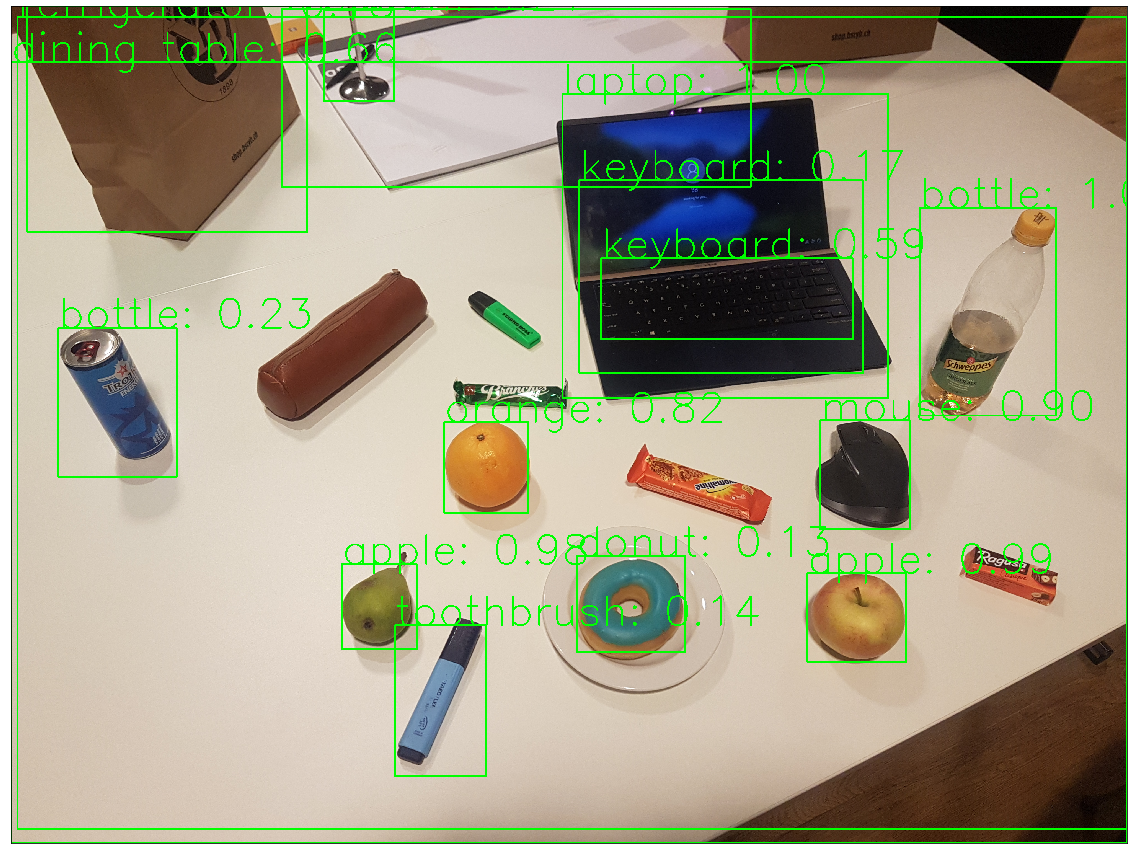

In [32]:
object_detection_api('/home/matt/polybox/Fotos/Yb/20191116_010804.jpg', rect_th=6, text_th=5, text_size=5)

In [11]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       